https://www.kaggle.com/code/gpiosenka/animal-faces-f1-test-score-99-7

### 필요한 라이브러리 호출

In [1]:
# 코랩에서 구글 드라이브 접근
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
import albumentations as A
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


### 지정된 RGB 전경색 및 배경색으로 텍스트를 인쇄하는 함수 정의

In [3]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



### dataframe 개수 plot 그리는 함수 정의

In [4]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5))
        form = {'family': 'serif', 'color': 'blue', 'size': 25}
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')
        plt.show()

### 잘못된 결함 없는지 확인하는 함수 정의

In [5]:
def image_eval(imgdir):
    flist=sorted(os.listdir(imgdir))
    wt=0
    ht=0
    total_good_images=0
    bad_images=[]
    for f in tqdm(flist, ncols=120, colour='blue', unit='files'):
        fpath=os.path.join(imgdir,f)
        try:
            img=cv2.imread(fpath)
            ht +=img.shape[0]
            wt +=img.shape[1]
            total_good_images +=1
        except:
            bad_images.append(fpath)
    wave=int(wt/total_good_images)
    have=int(ht/total_good_images)
    print('average images height= ', have, '  average image width= ', wave)
    if len(bad_images) >0:
        print('len(bad_images) images were found and are listed below')
        for f in bad_images:
            print (f)
    else:
        print(' There were no defective images found so the csv file does not need to be purged')
    return
imgdir=r'/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images'
image_eval(imgdir)

100%|██████████████████████████████████████████████████████████████████████████| 12568/12568 [06:50<00:00, 30.65files/s]

average images height=  256   average image width=  1600
 There were no defective images found so the csv file does not need to be purged


### 데이터 불러오기

In [6]:
imgdir=r'/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images'
df=pd.read_csv(r'/content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train.csv')
df=df.drop('EncodedPixels', axis=1)
df.columns=['filepaths', 'labels']
df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(imgdir,x))
df['labels'] =df['labels'].apply(lambda x: str(x))
print(df.head())

                                                                                 filepaths  \
0  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/0002cc93b.jpg   
1  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/0007a71bf.jpg   
2  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/000a4bcdd.jpg   
3  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/000f6bf48.jpg   
4  /content/drive/MyDrive/졸업과제/severstal-steel-defect-detection/train_images/0014fce06.jpg   

  labels  
0      1  
1      3  
2      1  
3      4  
4      3  


0.8:0.1:0.1 비율로 데이터셋 나누기

In [7]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=123, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    return train_df, test_df, valid_df

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  5676   test_df length:  710   valid_df length:  709


3    4120
1     718
4     641
2     197
Name: labels, dtype: int64


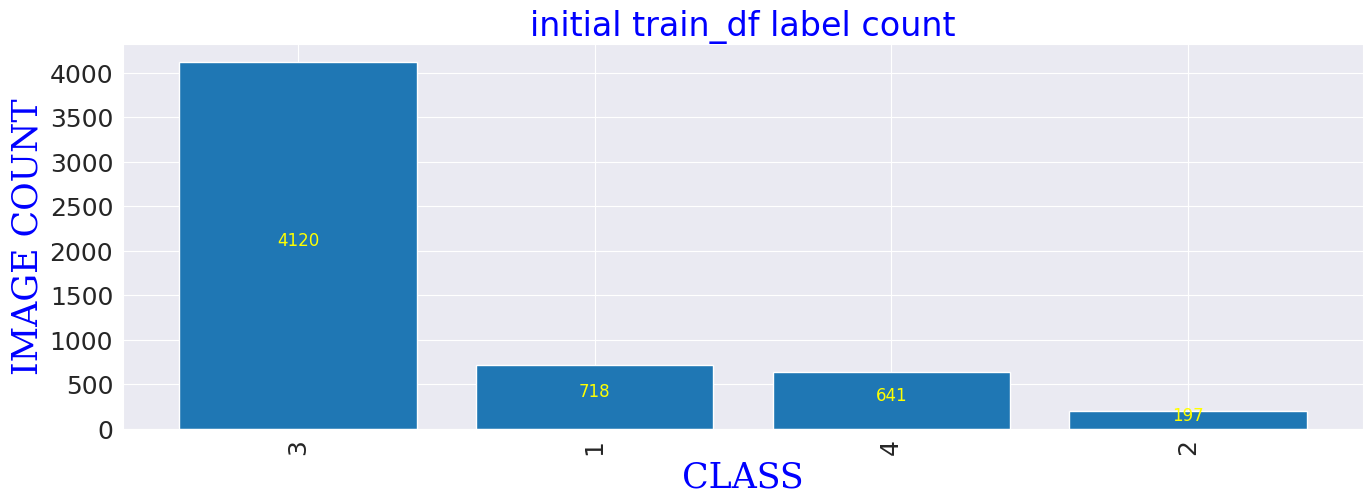

In [8]:
count=train_df['labels'].value_counts()
print (count)
plot_title='initial train_df label count'
plot_label_count (train_df, plot_title)

### 데이터 max 1000 개, min 197개로 균형

In [9]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique() # return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=1000
min_samples= 197
column='labels'
train_df, classes, class_count= trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  5676  with  4  classes
after trimming, the maximum samples in any class is now  1000  and the minimum samples in any class is  197
the trimmed dataframe now is of length  2556  with  4  classes


### 데이터 증강

In [10]:
def balance(df, n,column, working_dir, img_size):
    def get_augmented_image(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df[column].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path)

    total=0
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count< n:
            aug_img_count=0
            delta=n - sample_count
            target_dir=os.path.join(aug_dir, label)
            desc=f'augmenting class {label}'
            for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
                j= i % sample_count
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('Total Augmented images created= ', total)

    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=1000
working_dir=r'/content/drive/MyDrive/졸업과제/working'
img_size = (100,625)
column='labels'
train_df=balance(train_df, n,column, working_dir, img_size)

Initial length of dataframe is  2556


augmenting class 2: 100%|██████████████████████████████████████████████████████████| 803/803 [00:21<00:00, 37.81files/s]

Total Augmented images created=  1444
Length of augmented dataframe is now  4000


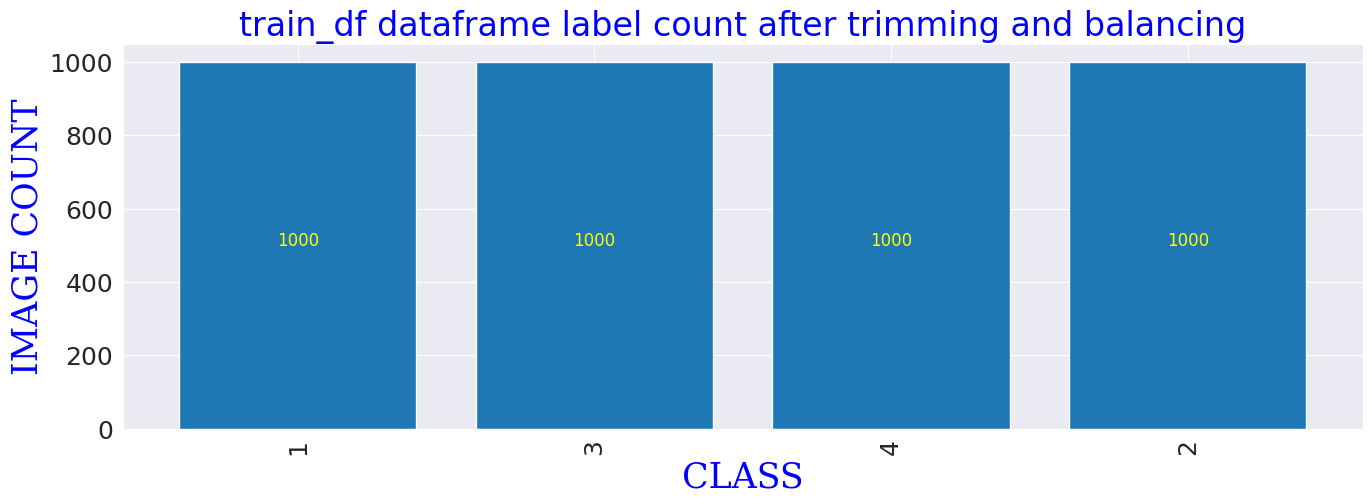

In [11]:
plot_title='train_df dataframe label count after trimming and balancing'
plot_label_count (train_df, plot_title)

### train, test, valid

In [12]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

bs=30
ycol='labels'
train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_df, test_df, valid_df, img_size)


Found 4000 validated image filenames belonging to 4 classes.
Found 709 validated image filenames belonging to 4 classes.
Found 710 validated image filenames belonging to 4 classes.
test batch size:  71   test steps:  10  number of classes :  4


train 예시 출력

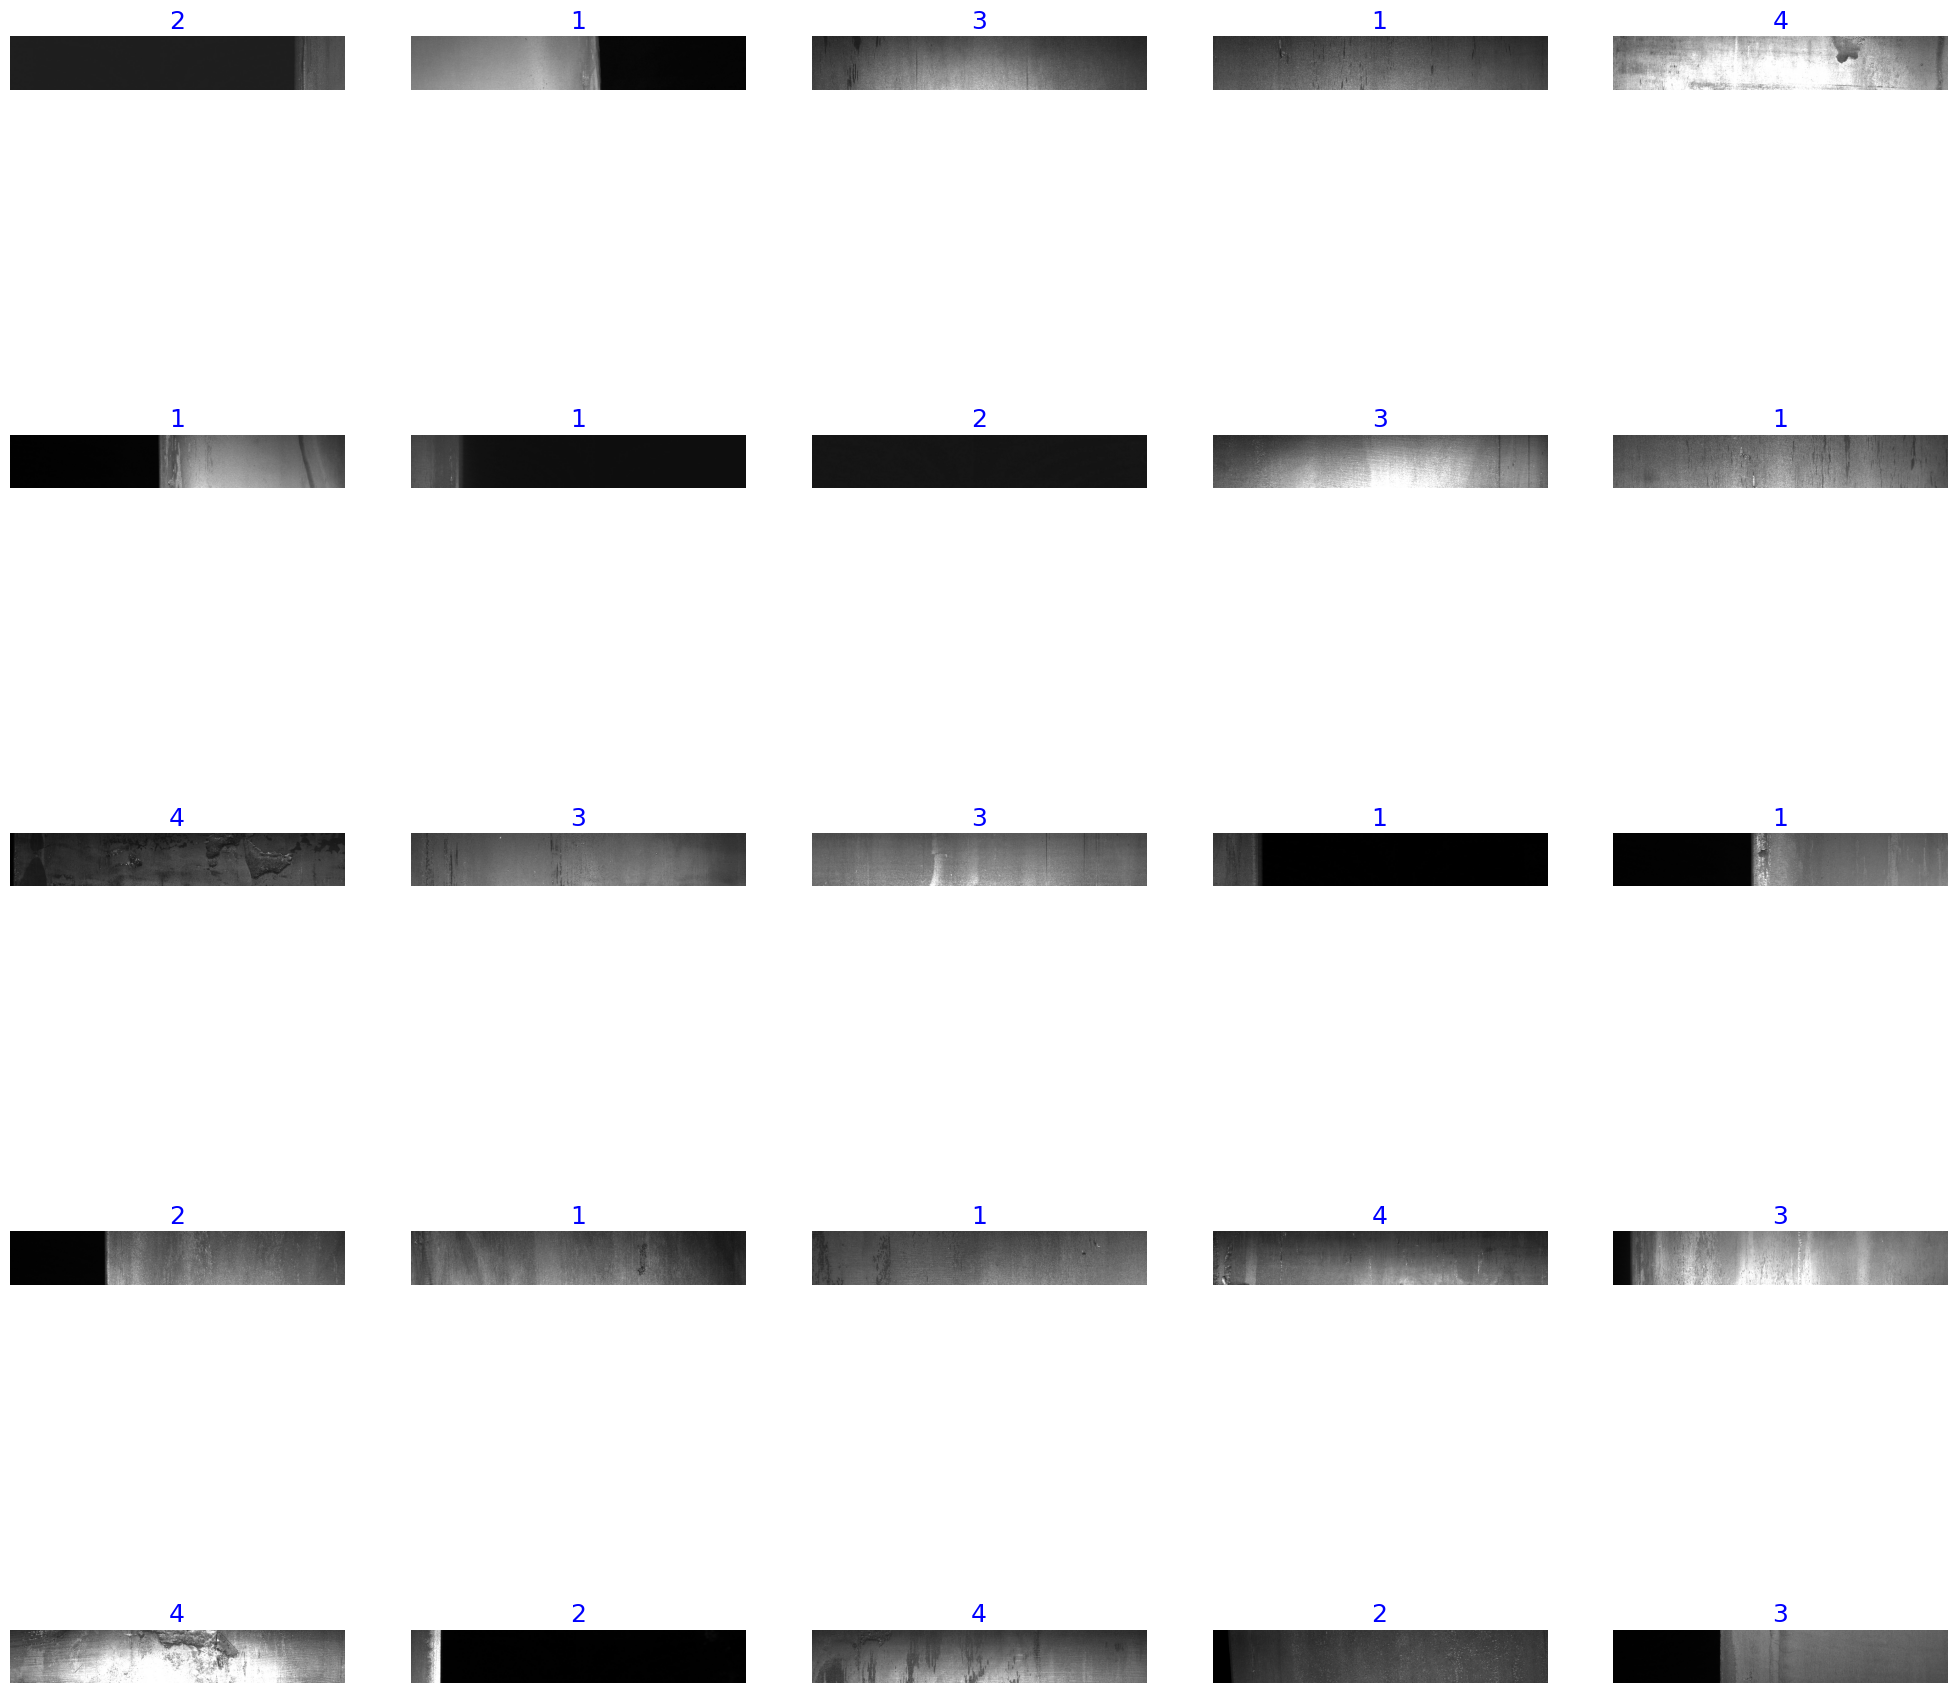

In [13]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

### fl score 산출 함수

In [14]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### EfficientNet 모델 정의


In [15]:
def make_model(img_size, lr, mod_num=3):
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:

        base_model=tf.keras.applications.efficientnet.EfficientNetB0(
            include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B5 model'
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'

    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC'])
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

### 학습 결과 plot 함수

In [17]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    tauc=tr_data.history['auc']
    vauc=tr_data.history['val_auc']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    axes[3].plot(Epochs,tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs,vauc,'g',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=sc_label)
    axes[3].scatter(Epochs, tauc, s=100, c='red')
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout
    plt.show()
    return

### EfficientNet B3 모델 학습

In [18]:
lr=.001
model=make_model(img_size, lr) # using B3 model by default
epochs=50
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)
callbacks=[early_stopping]

43941136/43941136 [==============================] - 3s 0us/step
Created EfficientNet B3 model with initial learning rate set to 0.001



In [19]:
history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

ask_epoch >= epochs, will train for  50  epochs
Training will proceed until epoch 50 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 7.2524 - accuracy: 0.7270 - F1_score: 0.7214 - auc: 0.9028
 validation loss of  5.9554 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

134/134 [==============================] - 172s 706ms/step - loss: 7.2524 - accuracy: 0.7270 - F1_score: 0.7214 - auc: 0.9028 - val_loss: 5.9554 - val_accuracy: 0.7659 - val_F1_score: 0.7563 - val_auc: 0.9232
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 4.9175 - accuracy: 0.8587 - F1_score: 0.8548 - auc: 0.9664
 validation loss of  4.3547 is 26.8772 % below lowest loss, saving weights from epoch 2   as best weights

134/134 [==============================] - 91s 

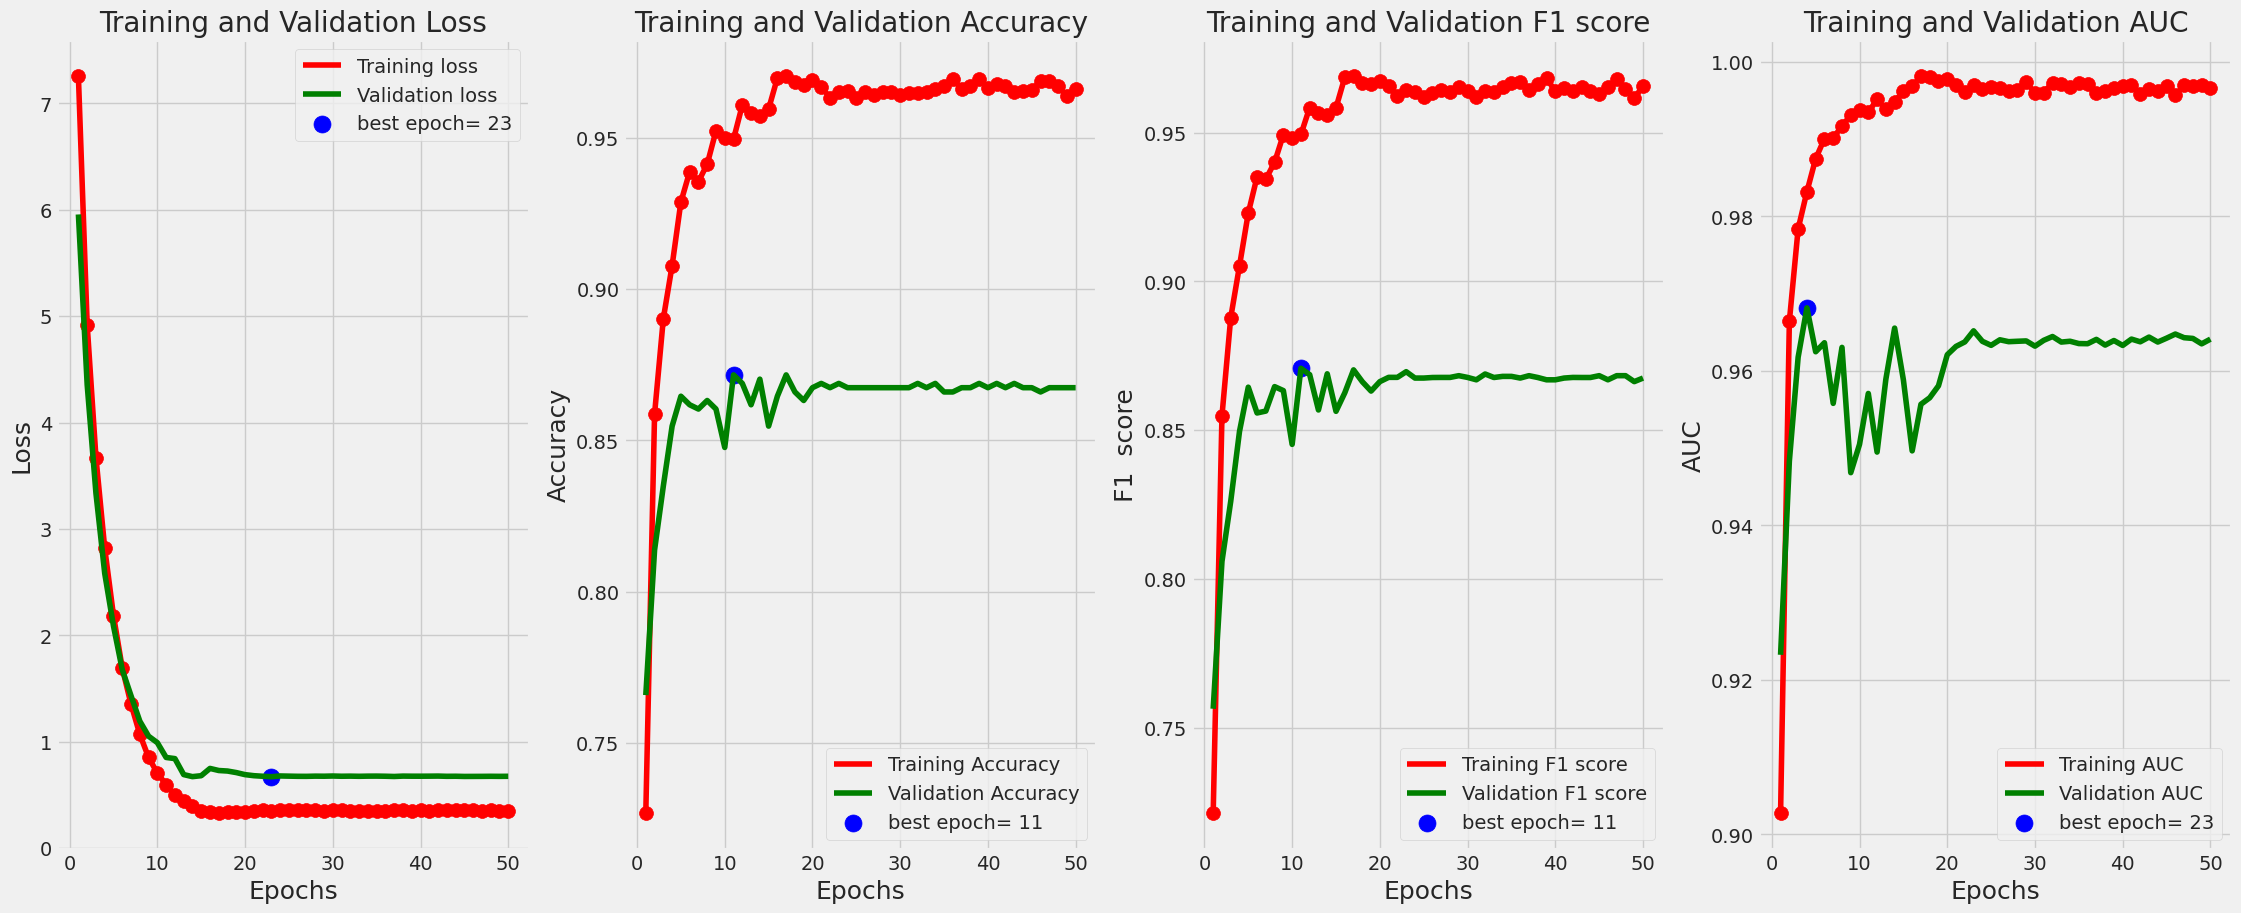

In [20]:
tr_plot(history)

In [28]:
ee = 30
print(history.history['accuracy'][ee])
print(history.history['val_accuracy'][ee])
print()
print(history.history['loss'][ee])
print(history.history['val_loss'][ee])
print()
print(history.history['F1_score'][ee])
print(history.history['val_F1_score'][ee])
print()
print(history.history['auc'][ee])
print(history.history['val_auc'][ee])

0.9647499918937683
0.8674188852310181

0.3588694632053375
0.6764878630638123

0.9619658589363098
0.86692875623703

0.9960243105888367
0.9639616012573242


### EfficientNetB0 모델 학습

In [22]:
lr = .001
model_B0 = make_model(img_size, lr, 0)
epochs = 50
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)
callbacks=[early_stopping]

history_B0 = model_B0.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

16705208/16705208 [==============================] - 2s 0us/step
Created EfficientNet B0 model with initial learning rate set to 0.001

ask_epoch >= epochs, will train for  50  epochs
Training will proceed until epoch 50 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 7.2127 - accuracy: 0.7222 - F1_score: 0.7139 - auc: 0.9059
 validation loss of  6.1962 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

134/134 [==============================] - 95s 396ms/step - loss: 7.2127 - accuracy: 0.7222 - F1_score: 0.7139 - auc: 0.9059 - val_loss: 6.1962 - val_accuracy: 0.7447 - val_F1_score: 0.7363 - val_auc: 0.9163
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 4.9387 - accuracy: 0.8590 - F1_score: 0.8549 - auc: 0.9683
 validation loss of

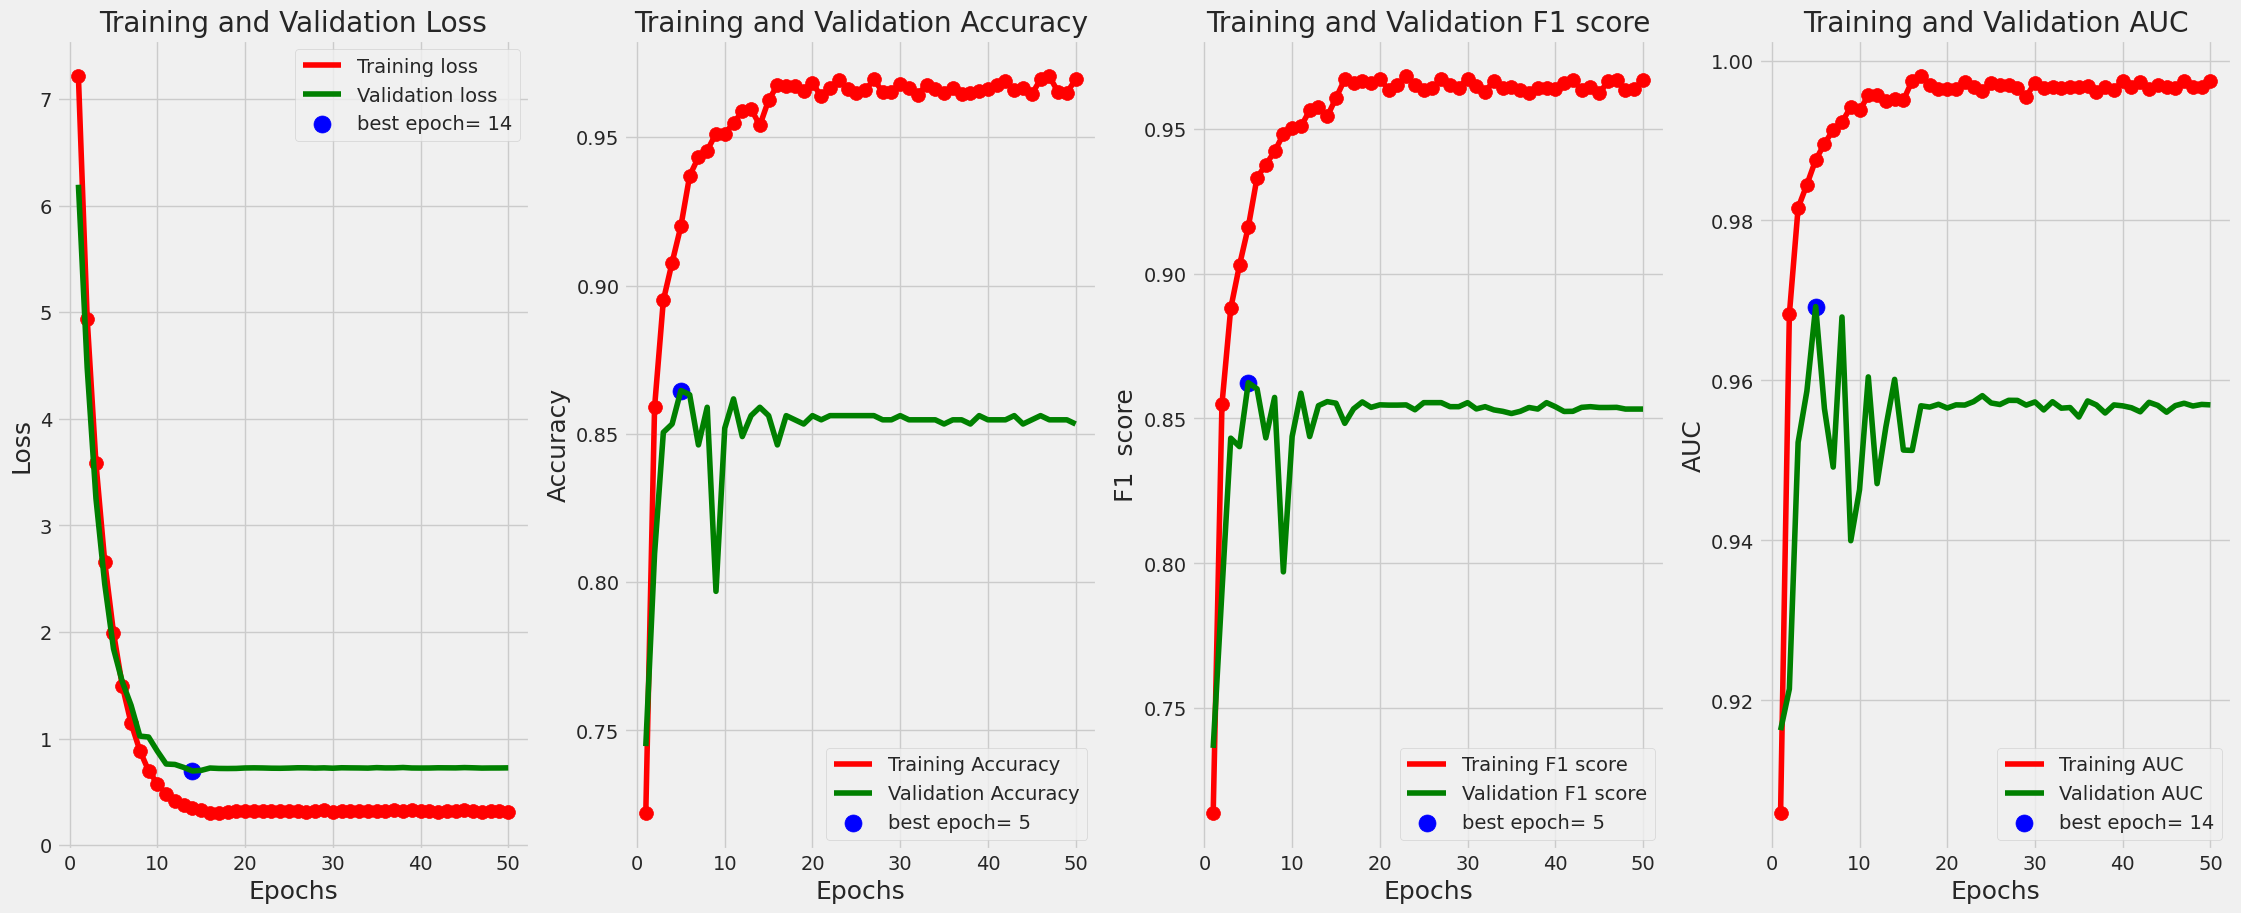

In [23]:
tr_plot(history_B0)

In [27]:
ee = 30
print(history_B0.history['accuracy'][ee])
print(history_B0.history['val_accuracy'][ee])
print()
print(history_B0.history['loss'][ee])
print(history_B0.history['val_loss'][ee])
print()
print(history_B0.history['F1_score'][ee])
print(history_B0.history['val_F1_score'][ee])
print()
print(history_B0.history['auc'][ee])
print(history_B0.history['val_auc'][ee])

0.9664999842643738
0.8547249436378479

0.3203466832637787
0.7260858416557312

0.9648358821868896
0.8532797694206238

0.996614933013916
0.9563086032867432


### EfficientNetB5 모델 학습

In [29]:
lr = .001
model_B5 = make_model(img_size, lr, 5)
epochs = 50

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)
callbacks=[early_stopping]

history_B5 = model_B5.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Created EfficientNet B5 model with initial learning rate set to 0.001

Epoch 1/50


ResourceExhaustedError: ignored

In [ ]:
tr_plot(history_B5)

### EfficientNetB7 모델 학습

In [26]:
lr = .001
model_B7 = make_model(img_size, lr, 7)
epochs = 50
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)
callbacks=[early_stopping]

history_B7 = model_B7.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

258076736/258076736 [==============================] - 13s 0us/step
Created EfficientNet B7 model with initial learning rate set to 0.001

Training will proceed until epoch 30 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/50


ResourceExhaustedError: ignored

In [ ]:
tr_plot(history_B7)